In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import warnings
import math
import matplotlib.pyplot as plt

df_train = pd.read_csv('../data/train.csv', index_col=0)
df_val = pd.read_csv('../data/val.csv', index_col=0)
df_test = pd.read_csv('../data/test.csv', index_col=0)

print("\n".join(map(lambda x: f"- {x}", df_train.columns)))

- resolution
- brand_name
- description
- name_rus
- CommercialTypeName4
- rating_1_count
- rating_2_count
- rating_3_count
- rating_4_count
- rating_5_count
- comments_published_count
- photos_published_count
- videos_published_count
- PriceDiscounted
- item_time_alive
- item_count_fake_returns7
- item_count_fake_returns30
- item_count_fake_returns90
- item_count_sales7
- item_count_sales30
- item_count_sales90
- item_count_returns7
- item_count_returns30
- item_count_returns90
- GmvTotal7
- GmvTotal30
- GmvTotal90
- ExemplarAcceptedCountTotal7
- ExemplarAcceptedCountTotal30
- ExemplarAcceptedCountTotal90
- OrderAcceptedCountTotal7
- OrderAcceptedCountTotal30
- OrderAcceptedCountTotal90
- ExemplarReturnedCountTotal7
- ExemplarReturnedCountTotal30
- ExemplarReturnedCountTotal90
- ExemplarReturnedValueTotal7
- ExemplarReturnedValueTotal30
- ExemplarReturnedValueTotal90
- ItemVarietyCount
- ItemAvailableCount
- seller_time_alive_x
- ItemID
- return_rate_30
- fake_return_rate_30
- refund_

In [52]:
import hydra
from omegaconf import OmegaConf
from hydra import compose, initialize

with initialize(config_path="../src/config"):
    cfg = compose(config_name="config")
print(OmegaConf.to_yaml(cfg))

C:\Users\luiza\AppData\Local\Temp\ipykernel_25604\1504901832.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../src/config"):


preprocessing:
  text:
    apply_cleaning: true
    apply_lemmatization: true
    add_fraud_indicators: true
    max_length: 1024
    nltk_data_dir: ${oc.env:NLTK_DATA,${hydra:runtime.cwd}/nltk_data}
  image:
    size:
    - 224
    - 224
    augmentations:
    - transform:
        _target_: torchvision.transforms.RandomResizedCrop
        size: 224
        scale:
        - 0.8
        - 1.0
      probability: 0.5
    - transform:
        _target_: torchvision.transforms.RandomHorizontalFlip
        p: 0.5
      probability: 0.1
    - transform:
        _target_: torchvision.transforms.RandomRotation
        degrees: 10
      probability: 0.3
    - transform:
        _target_: torchvision.transforms.ColorJitter
        brightness: 0.1
        contrast: 0.1
        saturation: 0.1
        hue: 0.05
      probability: 0.3
    compute_clip_similarity: false
    clip_model: openai/clip-vit-base-patch32
  tabular:
    categorical_cols:
    - brand_name
    - CommercialTypeName4
    numerica

In [53]:
from typing import List, Dict, Any

class TabularProcessor:
    def __init__(self,
                 categorical_cols: List[str] = None,
                 numerical_cols: List[str] = None,
                 scaling: str = "standard"):
        self.categorical_cols = categorical_cols or []
        self.numerical_cols = numerical_cols or []
        self.scaling = scaling

        # Learned state
        self.category_value_to_index: Dict[str, Dict[Any, int]] = {}
        self.category_cardinalities: List[int] = []
        self.num_stats: Dict[str, Dict[str, float]] = {}
        self.num_categorical_features: int = 0
        self.num_continuous_features: int = 0

    def fit(self, df: pd.DataFrame) -> None:
        """
        Fit encoders and scalers on training dataframe.

        - Categorical columns: build value->index mapping with 0 reserved for unknown/missing
        - Numerical columns: compute mean/std (standard) or min/max (minmax)
        """
        # Fit categoricals
        self.category_value_to_index = {}
        self.category_cardinalities = []
        for col in self.categorical_cols:
            # Get unique values excluding NaNs
            if col not in df.columns:
                # still register unknown-only category
                self.category_value_to_index[col] = {}
                self.category_cardinalities.append(1)
                continue
            values = pd.Series(df[col]).astype(str)
            # Include only non-null values
            unique_values = pd.Index(values[values != 'nan'].unique())
            # Reserve 0 for unknown
            mapping = {val: i + 1 for i, val in enumerate(unique_values)}
            self.category_value_to_index[col] = mapping
            # cardinality includes index 0 for unknown
            self.category_cardinalities.append(len(mapping) + 1)

        # Fit numerical scaler
        self.num_stats = {}
        for col in self.numerical_cols:
            if col not in df.columns:
                self.num_stats[col] = {"mean": 0.0, "std": 1.0, "min": 0.0, "max": 1.0}
                continue
            series = pd.to_numeric(df[col], errors='coerce')
            if self.scaling == "standard":
                mean = float(series.mean()) if not math.isnan(series.mean()) else 0.0
                std = float(series.std(ddof=0)) if not math.isnan(series.std(ddof=0)) else 1.0
                if std == 0.0:
                    std = 1.0
                self.num_stats[col] = {"mean": mean, "std": std}
            elif self.scaling == "minmax":
                min_v = float(series.min()) if not math.isnan(series.min()) else 0.0
                max_v = float(series.max()) if not math.isnan(series.max()) else 1.0
                if max_v == min_v:
                    max_v = min_v + 1.0
                self.num_stats[col] = {"min": min_v, "max": max_v}
            else:
                # No scaling
                self.num_stats[col] = {}

        # Store feature counts
        self.num_categorical_features = len(self.categorical_cols)
        self.num_continuous_features = len(self.numerical_cols)

    @property
    def categories_cardinalities(self) -> List[int]:
        return list(self.category_cardinalities)

    @property
    def num_continuous(self) -> int:
        return len(self.numerical_cols)

    def _encode_category_value(self, col: str, value: Any) -> int:
        mapping = self.category_value_to_index.get(col, {})
        if pd.isna(value):
            return 0
        key = str(value)
        return mapping.get(key, 0)

    def _scale_numeric_value(self, col: str, value: Any) -> float:
        if value is None or (isinstance(value, float) and math.isnan(value)):
            # impute with mean (standard) or min (minmax) or 0
            if self.scaling == "standard":
                return float(self.num_stats.get(col, {}).get("mean", 0.0))
            elif self.scaling == "minmax":
                return float(self.num_stats.get(col, {}).get("min", 0.0))
            else:
                return 0.0
        try:
            v = float(value)
        except Exception:
            v = 0.0
        if self.scaling == "standard":
            mean = self.num_stats.get(col, {}).get("mean", 0.0)
            std = self.num_stats.get(col, {}).get("std", 1.0)
            return (v - mean) / std
        if self.scaling == "minmax":
            min_v = self.num_stats.get(col, {}).get("min", 0.0)
            max_v = self.num_stats.get(col, {}).get("max", 1.0)
            return (v - min_v) / (max_v - min_v)
        return v

    def __call__(self, row: Dict[str, Any]) -> np.array:
        # Categorical indices
        cat_indices: List[int] = []
        for col in self.categorical_cols:
            val = row.get(col, None)
            idx = self._encode_category_value(col, val)
            cat_indices.append(idx)

        # Continuous values
        cont_values: List[float] = []
        for col in self.numerical_cols:
            val = row.get(col, None)
            scaled = self._scale_numeric_value(col, val)
            cont_values.append(float(scaled))

        categorical = np.array(cat_indices)
        continuous = np.array(cont_values) if cont_values else np.zeros(0)

        return np.concat([categorical, continuous])

In [54]:
processor = TabularProcessor(categorical_cols=list(cfg.preprocessing.tabular.categorical_cols),
            numerical_cols=list(cfg.preprocessing.tabular.numerical_cols),
            scaling=cfg.preprocessing.tabular.get('scaling', 'standard'))

processor.fit(df_train)

In [55]:
def process_data(df_train, df_val, df_test):
    X_train, y_train = df_train.drop(columns='resolution'), df_train['resolution']
    X_val, y_val = df_val.drop(columns='resolution'), df_val['resolution']
    X_test = df_test.copy()
    X_train = np.stack(X_train.apply(processor, axis=1))
    X_val = np.stack(X_val.apply(processor, axis=1))
    X_test = np.stack(X_test.apply(processor, axis=1))
    
    return (X_train, y_train), (X_val, y_val), X_test

In [56]:
X_train, y_train = df_train.drop(columns='resolution'), df_train['resolution']
X_val, y_val = df_val.drop(columns='resolution'), df_val['resolution']
X_test = df_test.copy()
X_train = np.stack(X_train.apply(processor, axis=1))
X_val = np.stack(X_val.apply(processor, axis=1))
X_test = np.stack(X_test.apply(processor, axis=1))

In [57]:
from catboost import CatBoostClassifier

def train(X_train, y_train, X_val, y_val):
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        verbose=100
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

    val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)

    print(f"Validation accuracy: {val_accuracy:.4f}")
    print("Classification report:")
    print(classification_report(y_val, val_pred))
    print()

    return model

In [58]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)

print(f"Validation accuracy: {val_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_val, val_pred))
print()

0:	learn: 0.5584283	test: 0.5594011	best: 0.5594011 (0)	total: 58.4ms	remaining: 29.1s
100:	learn: 0.1108101	test: 0.1153779	best: 0.1153779 (100)	total: 7.2s	remaining: 28.4s
200:	learn: 0.0945609	test: 0.1007037	best: 0.1007037 (200)	total: 14.3s	remaining: 21.2s
300:	learn: 0.0851548	test: 0.0935687	best: 0.0935687 (300)	total: 20.9s	remaining: 13.8s
400:	learn: 0.0787441	test: 0.0892084	best: 0.0892084 (400)	total: 27.3s	remaining: 6.73s
499:	learn: 0.0725364	test: 0.0852351	best: 0.0852351 (499)	total: 34.8s	remaining: 0us

bestTest = 0.08523506335
bestIteration = 499

Validation accuracy: 0.9701
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     36830
           1       0.84      0.68      0.75      2610

    accuracy                           0.97     39440
   macro avg       0.91      0.83      0.87     39440
weighted avg       0.97      0.97      0.97     39440




In [59]:
def show_importance(model):
    # Calculate importance (default: PredictionValuesChange)
    importances = model.get_feature_importance(type='PredictionValuesChange')
    feat_imp = pd.Series(importances, index=processor.categorical_cols + processor.numerical_cols).sort_values(ascending=False)

    print(feat_imp)

    # Visualize top features
    plt.figure(figsize=(8, 6))
    feat_imp.head(30).sort_values().plot.barh()
    plt.title("CatBoost Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

CommercialTypeName4               15.265080
brand_name                         6.535618
seller_avg_price                   4.630185
seller_avg_item_time_alive         4.582464
seller_median_price                4.377973
                                    ...    
fraud_desc_short_description       0.000000
fraud_title_messenger              0.000000
fraud_title_brand_names            0.000000
fraud_desc_suspicious_keywords     0.000000
fraud_title_suspicious_numbers     0.000000
Length: 100, dtype: float64


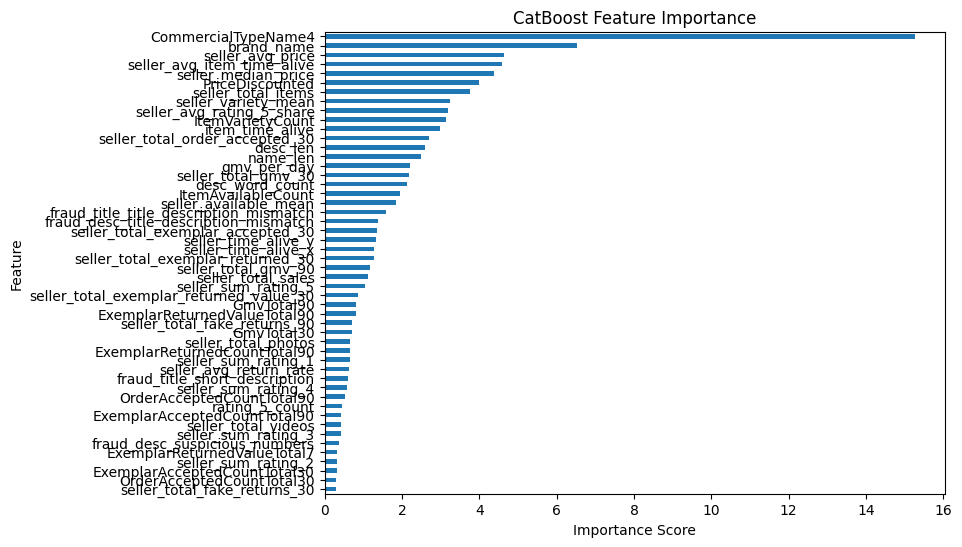

In [60]:
import matplotlib.pyplot as plt

# Calculate importance (default: PredictionValuesChange)
importances = model.get_feature_importance(type='PredictionValuesChange')
feat_imp = pd.Series(importances, index=processor.categorical_cols + processor.numerical_cols).sort_values(ascending=False)

print(feat_imp)

# Visualize top features
plt.figure(figsize=(8, 6))
feat_imp.head(50).sort_values().plot.barh()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [64]:
print(feat_imp[:50])

CommercialTypeName4                        15.265080
brand_name                                  6.535618
seller_avg_price                            4.630185
seller_avg_item_time_alive                  4.582464
seller_median_price                         4.377973
PriceDiscounted                             3.981302
seller_total_items                          3.764539
seller_variety_mean                         3.256093
seller_avg_rating_5_share                   3.197875
ItemVarietyCount                            3.130361
item_time_alive                             2.972595
seller_total_order_accepted_30              2.701289
desc_len                                    2.601923
name_len                                    2.501957
gmv_per_day                                 2.200865
seller_total_gmv_30                         2.190672
desc_word_count                             2.120623
ItemAvailableCount                          1.944652
seller_available_mean                       1.

In [62]:
print("\n".join(map(lambda x: f'- {x}', list(feat_imp[:50].index))))

- CommercialTypeName4
- brand_name
- seller_avg_price
- seller_avg_item_time_alive
- seller_median_price
- PriceDiscounted
- seller_total_items
- seller_variety_mean
- seller_avg_rating_5_share
- ItemVarietyCount
- item_time_alive
- seller_total_order_accepted_30
- desc_len
- name_len
- gmv_per_day
- seller_total_gmv_30
- desc_word_count
- ItemAvailableCount
- seller_available_mean
- fraud_title_title_description_mismatch
- fraud_desc_title_description_mismatch
- seller_total_exemplar_accepted_30
- seller_time_alive_y
- seller_time_alive_x
- seller_total_exemplar_returned_30
- seller_total_gmv_90
- seller_total_sales
- seller_sum_rating_5
- seller_total_exemplar_returned_value_30
- GmvTotal90
- ExemplarReturnedValueTotal90
- seller_total_fake_returns_90
- GmvTotal30
- seller_total_photos
- ExemplarReturnedCountTotal90
- seller_sum_rating_1
- seller_avg_return_rate
- fraud_title_short_description
- seller_sum_rating_4
- OrderAcceptedCountTotal90
- rating_5_count
- ExemplarAcceptedCountT

In [ ]:
"""
df_train_selected = df_train[list(feat_imp[:30].index) + ['resolution']]
df_val_selected = df_val[list(feat_imp[:30].index) + ['resolution']]
df_test_selected = df_test[list(feat_imp[:30].index)]

processor.numerical_cols = list(feat_imp[:30].drop(processor.categorical_cols).index)
(X_train_sel, y_train_sel), (X_val_sel, y_val_sel), X_test_sel = process_data(df_train_selected, df_val_selected, df_test_selected)
model_sel = train(X_train_sel, y_train_sel, X_val_sel, y_val_sel)
show_importance(model_sel)
"""